In [28]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import hamming
from scipy.optimize import linear_sum_assignment
from time import time
from matplotlib import animation, rc
sns.set()
# Import Tabu Sampler
from tabu_class import tabu_sampler

@numba.njit()
def autocorr(x, lags):
    mean=np.mean(x)
    var=np.var(x)
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]

    return np.array(corr)

%matplotlib inline


Expected number of points |Y|: 59.86713811378254


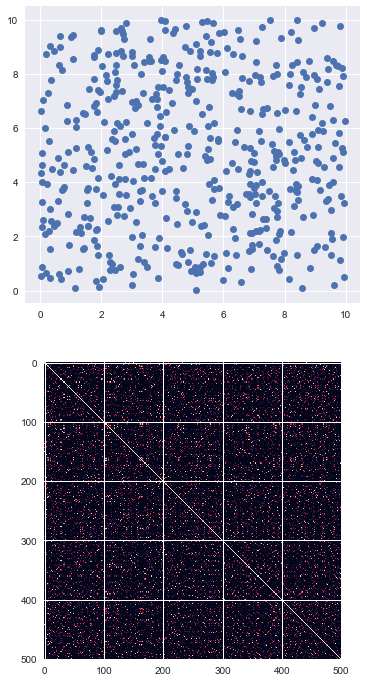

In [29]:
n = 500

high_val = 10.

observations = np.random.uniform(size=2*n, low = 0.0, high = high_val).reshape(n, 2)

sigma = np.sqrt(1)

K = np.zeros(n**2).reshape(n,n)

def K_kernel(i, j):
    return np.exp(-1/(2*sigma**2) * np.sum((observations[i, :] - observations[j, :])**2))

for i in np.arange(0, n):
    for j in np.arange(0, n):
        K[i, j] = K_kernel(i, j)

        
singular_values = np.linalg.svd(K)[1]
expected_points = np.sum(singular_values/(1+singular_values))
        
state = np.random.choice([0,1], size=n)

fig = plt.figure(figsize=(6,12))

ax1 = plt.subplot(211)
point_plot = ax1.plot(observations[:, 0], observations[:, 1], "o")

print("Expected number of points |Y|:", expected_points)

ax2 = plt.subplot(212)
matrix_plot = ax2.imshow(K)

In [30]:
def energy_func(state, K=K):
    
    indices = np.nonzero(np.ravel(state))[0]
    
    K_eval = K[indices, :]
    K_eval = K_eval[:, indices]
    
    return np.linalg.det(K_eval)

def calc_rates(state, jump_rates=0, jump_rates_sum=0, generator_index=0, K=K):
    rate_vector = np.zeros(n)
    
    base_energy = energy_func(state)
    
    for i in np.arange(n):
        flipped_state = state.copy()
        flipped_state[i] = 1 - flipped_state[i]
        
        indices = np.nonzero(np.ravel(flipped_state))[0]
        
        K_eval = K[indices, :]
        K_eval = K_eval[:, indices]
        
        det_ratio = np.linalg.det(K_eval)/base_energy
        
        #rate_vector[i] = np.sqrt(det_ratio)
        rate_vector[i] = det_ratio/(1+det_ratio)
            
    return rate_vector

def apply_gen(state, generator_index):
    updated_state = state.copy()
    updated_state[generator_index] = 1 - updated_state[generator_index]
    
    return updated_state

In [31]:
T = 600
thinning_ratio = 0.006
N = int(T/thinning_ratio)

samples, energy, hammings, alpha, iters, runtime = tabu_sampler(n, n,
                                                              energy_function=energy_func,
                                                              calculate_rates=calc_rates,
                                                              update_rates=calc_rates,
                                                              apply_generator=apply_gen,
                                                              current_state=np.zeros(n),
                                                              baseline_state=np.ones(n),
                                                              target_time=T,
                                                              thin_rate=thinning_ratio,
                                                              time_change_rate=10e-10,
                                                              symmetry=False,
                                                              SAW_bool=True,
                                                              print_output=False,
                                                              calc_hamming=False)

# Update type of samples
samples = samples.astype("int8") 

Percent: [--------------------------------------->] 100%[600.0113103]
Average SAW length: 11.0
Average jump length: [0.0194512]
Runtime: 1033.8


Mean number of samples: 59.97731


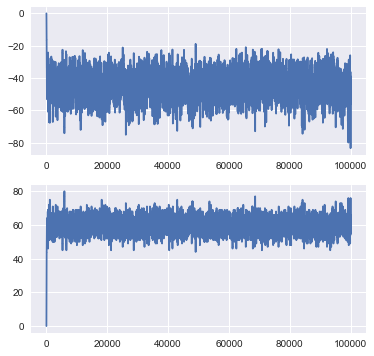

In [32]:
%matplotlib inline
plt.figure(figsize=(6,6))
ax1 = plt.subplot(211)
ax1.plot(np.arange(0, N), np.log(energy))
ax2 = plt.subplot(212)
ax2.plot(np.arange(0, N), samples.sum(axis=1))
print("Mean number of samples:", np.mean(samples.sum(axis=1)))

Total ESS: 2159.687739265898
ESS/S: 2.08908561205696


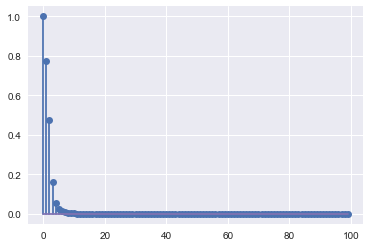

In [33]:
fig, ax = plt.subplots()
ax.stem(autocorr(energy[int(0.2*N):], np.arange(0, 100)))
ESS_E = N/(1+2*sum(autocorr(samples.sum(axis=1)[int(0.2*N):], np.arange(0, 3000))))
print("Total ESS:", ESS_E)
print("ESS/S:", ESS_E/runtime)

In [34]:
T = 1000
thinning_ratio = 0.01
N = int(T/thinning_ratio)

samples_z, energy_z, hammings, alpha, iters, runtime_z = tabu_sampler(n, n,
                                                              energy_function=energy_func,
                                                              calculate_rates=calc_rates,
                                                              update_rates=calc_rates,
                                                              apply_generator=apply_gen,
                                                              current_state=np.zeros(n),
                                                              baseline_state=np.ones(n),
                                                              target_time=T,
                                                              thin_rate=thinning_ratio,
                                                              time_change_rate=10,
                                                              symmetry=False,
                                                              SAW_bool=False,
                                                              print_output=False,
                                                              print_rate=1000,
                                                              calc_hamming=False)

# Update type of samples
samples_z = samples_z.astype("int8") 

Percent: [--------------------------------------->] 100%[1000.00571914]
Average jump length: [0.01063406]
Runtime: 3202.77


Total ESS: 1676.1787613326967
ESS/S: 0.5233530878425929


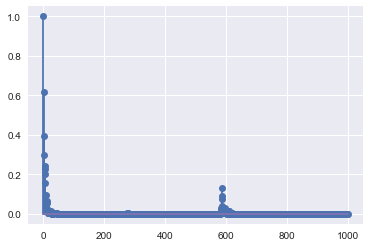

In [35]:
fig, ax = plt.subplots()
ax.stem(autocorr(energy_z[int(0.2*N):], np.arange(0, 1000)))
ESS_E = N/(1+2*sum(autocorr(samples_z.sum(axis=1)[int(0.2*N):], np.arange(0, 3000))))
print("Total ESS:", ESS_E)
print("ESS/S:", ESS_E/runtime_z)

Mean number of samples: 60.09416


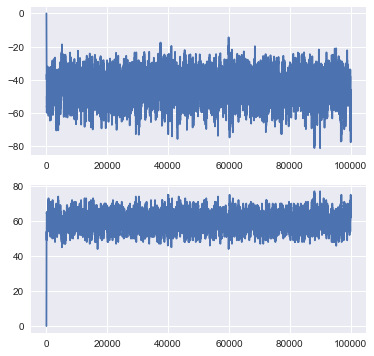

In [27]:
%matplotlib inline
plt.figure(figsize=(6,6))
ax1 = plt.subplot(211)
ax1.plot(np.arange(0, N), np.log(energy_z))
ax2 = plt.subplot(212)
ax2.plot(np.arange(0, N), samples_z.sum(axis=1))
print("Mean number of samples:", np.mean(samples_z.sum(axis=1)))